In [1]:
!nvidia-smi

Thu Jul 21 20:14:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Don't forget to switch to a GPU-enabled colab runtime!

```
Runtime -> Change Runtime Type -> GPU
```

# Unzip dataset

In [3]:
import os
os.system("cp drive/MyDrive/duckietown_dataset.zip duckietown_dataset.zip")
os.system("unzip duckietown_dataset.zip")
os.system("rm duckietown_dataset.zip")

0

# Next, we will clone Yolov5 into this colab notebook

In [4]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 12889, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 12889 (delta 37), reused 40 (delta 17), pack-reused 12825
Receiving objects: 100% (12889/12889), 12.39 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (8864/8864), done.


In [5]:
!cd yolov5/ && pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 5.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
!cd yolov5/data/ && touch duckietown.yaml
with open('yolov5/data/duckietown.yaml', 'w') as f:
    f.write("train: ../duckietown_dataset/train\n")
    f.write("val: ../duckietown_dataset/val\n")
    f.write("nc: 4\n")
    f.write("names: [ 'duckie', 'cone', 'truck', 'bus' ]")

# And we're ready to train!

Notice that we're only training for 10 epochs. That's probably not enough!

In [7]:
!cd yolov5/ && python3 train.py --img 416 --batch 16 --epochs 10 --data duckietown.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=duckietown.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-308-g602d7ff Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

# Export trained model to ONNX (Cpu) and TensorRT (Gpu)

In [8]:
!cd yolov5/ && python3 export.py --weights "runs/train/exp/weights/best.pt" --include engine --device 0 --imgsz=416 --half

export: data=data/coco128.yaml, weights=['runs/train/exp/weights/best.pt'], imgsz=[416], batch_size=1, device=0, half=True, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['engine']
YOLOv5 🚀 v6.1-308-g602d7ff Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/exp/weights/best.pt with output shape (1, 10647, 9) (13.7 MB)
requirements: nvidia-tensorrt not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.ngc.nvidia.com, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for nvidia-cublas-cu11: filename=nvidia_cublas_cu11-2022.4.8-py3-none-any.whl size=15624 sha256=154a7b4d28b4e9e68c4eea456

# Test model loading and inference

In [9]:
!cd yolov5/ && python3 detect.py --weights "runs/train/exp/weights/best.engine" --source "../duckietown_dataset/val/images" --device 0 --half --imgsz=416 --hide-labels

detect: weights=['runs/train/exp/weights/best.engine'], source=../duckietown_dataset/val/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=False, half=True, dnn=False
YOLOv5 🚀 v6.1-308-g602d7ff Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Loading runs/train/exp/weights/best.engine for TensorRT inference...
[07/21/2022-20:22:35] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 0, GPU 367 (MiB)
[07/21/2022-20:22:35] [TRT] [I] Loaded engine size: 16 MiB
[07/21/2022-20:22:36] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +15, now: CPU 0, GPU 15 (MiB)
[07/21/2022-20:22:37] [TRT] [I] [MemUsageChang

In [10]:
!cd yolov5/ && python3 detect.py --weights "runs/train/exp/weights/best.pt" --source "../duckietown_dataset/val/images" --device 0 --imgsz=416 --hide-labels

detect: weights=['runs/train/exp/weights/best.pt'], source=../duckietown_dataset/val/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-308-g602d7ff Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/200 /content/duckietown_dataset/val/images/1.jpg: 416x416 3 duckies, Done. (0.023s)
image 2/200 /content/duckietown_dataset/val/images/10.jpg: 416x416 3 duckies, Done. (0.011s)
image 3/200 /content/duckietown_dataset/val/images/103.jpg: 416x416 23 duckies, Done. (0.019s)
image 4/200 /content/duckietown_dataset/val/images/116.

# Load model directly into this notebook

In [11]:
os.chdir("yolov5/")

from models.common import DetectMultiBackend
from utils.torch_utils import select_device
from utils.general import non_max_suppression, scale_coords
from utils.augmentations import letterbox

device = select_device(0)
model = DetectMultiBackend("runs/train/exp/weights/best.engine", device=device, data="data/duckietown.yaml", dnn=False, fp16=True)
model.warmup(imgsz=(1 if model.pt else 1, 3, 416, 416))

os.chdir("/content/")

YOLOv5 🚀 v6.1-308-g602d7ff Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Loading runs/train/exp/weights/best.engine for TensorRT inference...


In [12]:
%matplotlib inline
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

data_dir = "duckietown_dataset/val/images/"
paths = os.listdir(data_dir)
paths.sort()

In [13]:
img = cv2.imread(f'{data_dir}{paths[5]}')
img = letterbox(img, 416, model.stride, model.pt)[0]
img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
img = np.ascontiguousarray(img)

img = torch.from_numpy(img).to(device)
img = img.half()
# img = img.float()
img /= 255
img = img[None]

In [14]:
pred = model(img, augment=False, visualize=False)
pred = non_max_suppression(pred, 0.25, 0.45, classes=None, agnostic=False, max_det=1000)

for det in pred[0]:
  # class conf y1 x1 y2 x2
  print(reversed(det))

tensor([  0.00000,   0.90869, 181.25000,  88.25000, 141.25000,  66.62500], device='cuda:0')
tensor([  0.00000,   0.90576, 164.25000, 363.75000, 136.00000, 340.25000], device='cuda:0')
tensor([  0.00000,   0.80908, 140.00000,  28.34375, 125.75000,  15.58594], device='cuda:0')
tensor([  0.00000,   0.77686, 141.50000, 251.37500, 124.25000, 240.62500], device='cuda:0')
tensor([  0.00000,   0.74365, 140.00000, 371.00000, 126.31250, 358.50000], device='cuda:0')
tensor([  0.00000,   0.74268, 131.25000, 177.12500, 122.31250, 170.87500], device='cuda:0')
tensor([  0.00000,   0.74268, 134.87500, 308.00000, 122.87500, 298.50000], device='cuda:0')
tensor([  0.00000,   0.74219, 128.62500, 402.25000, 113.18750, 383.25000], device='cuda:0')
tensor([  0.00000,   0.73975, 125.87500, 119.81250, 120.25000, 115.93750], device='cuda:0')
tensor([  0.00000,   0.70410, 127.12500, 339.00000, 119.75000, 333.00000], device='cuda:0')
tensor([  0.00000,   0.69531, 129.62500,  67.68750, 122.50000,  62.78125], devic

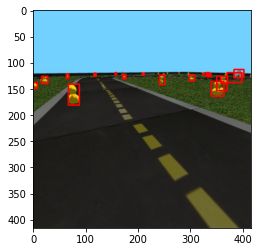

In [17]:
img_ = cv2.cvtColor(cv2.imread(f'{data_dir}{paths[5]}'), cv2.COLOR_BGR2RGB)

pred[0][:, :4] = scale_coords(img.shape[2:], pred[0][:, :4], img_.shape).round()
for det in pred[0]:
  det = reversed(det)
  det = det.cpu().numpy()
  cv2.rectangle(img_, (int(det[3]), int(det[2])), (int(det[5]), int(det[4])), (255,0,0), 2)

plt.imshow(img_)